In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import time


In [2]:

dfB = pd.read_csv("Datasets/skewed.csv",header = 0, sep=";")
XB = dfB.to_numpy()
XB




array([[1691, 1290],
       [1647, 1485],
       [1468, 1267],
       ...,
       [1736, 1684],
       [1602, 1199],
       [2038, 1835]], dtype=int64)

In [3]:
dfC = pd.read_csv("Datasets/fig2_panelC.csv",header = 0, sep=";")
XC = dfC.to_numpy()
XC

array([[-0.34576586,  0.7010113 ],
       [-0.34817964,  0.69643325],
       [-0.3435882 ,  0.69923502],
       ...,
       [-0.59184092,  1.26134372],
       [-0.07819092,  0.3031134 ],
       [-0.76162732,  0.38400239]])

<AxesSubplot:title={'center':'Scatter plot of the dataset'}, xlabel='X', ylabel='Y'>

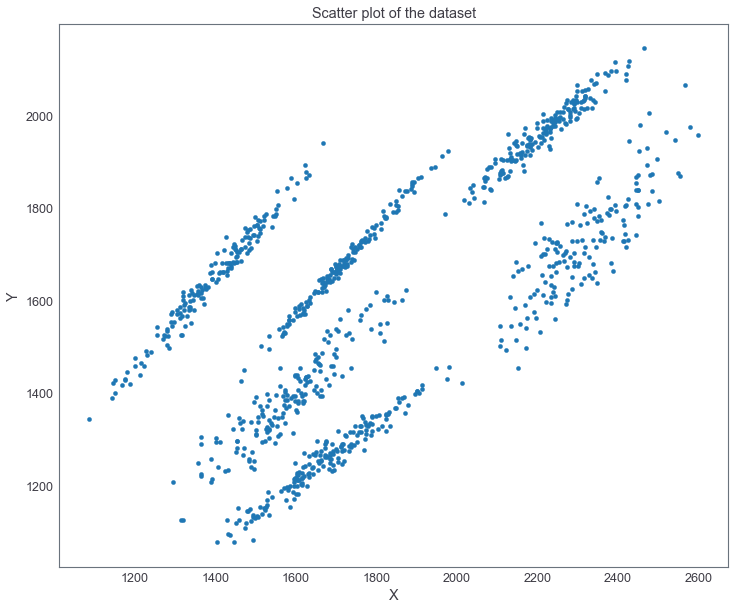

In [4]:
dfB.plot.scatter(x='X',y='Y',c='tab:blue',figsize=(12,10), title='Scatter plot of the dataset')


# Functions

In [5]:

def distance(array, metric ="euclidean"):
    return sklearn.metrics.pairwise_distances(array,metric=metric)
    
def local_density(cutoff, distances): # euclidian distance
    local_density = np.zeros(len(distances))
    for i in range(len(distances)) :
        # calculate the number of points which are closer than cutoff
        local_density[i] = (distances[i] < cutoff).sum()-1 # euclidian distance // -1 to remove self distance
    return local_density

def auto_cutoff(distances) :
    max_cutoff = np.max(distances)
    min_cutoff = np.min(distances)
    cutoff = (max_cutoff+min_cutoff)/2
    while True :
        target =  (distances <= cutoff).sum() / len(distances) ** 2
        if target > 0.01 and target < 0.02 :
            break
        if target < 0.01:
            min_cutoff = cutoff
        else:
            max_cutoff = cutoff
        cutoff = (max_cutoff + min_cutoff) / 2
        if max_cutoff - min_cutoff < 0.0001: 
            break 
    return cutoff

def delta_distance(rho, distances):
    desc_rho_idx = np.argsort(-rho)
    delta,neighbors = [0.0] + [float(np.max(distances))] * (len(distances)-1), [desc_rho_idx[0]] * len(distances)
    desc_distances = distances[desc_rho_idx]
    delta[desc_rho_idx[0]] = -1.
    for i in range(1,len(desc_distances)) : # find the min of pairwise distance for the i-th point from distance array
        filtered_row = desc_distances[i][desc_rho_idx[:i+1]]
        mask_nonzero = np.ma.masked_equal(filtered_row, 0.0, copy=False) # remove distance of 0.0
        delta[desc_rho_idx[i]] = mask_nonzero.min() # find min
        neighbors[desc_rho_idx[i]] = np.where(desc_distances[i] == mask_nonzero.min())[0][0] # find 
        # first index for neighbor
    delta[desc_rho_idx[0]] = max(delta)
    return delta, neighbors
    
def clustering(rho,delta,neighbors, distance_threshold, density_threshold, cutoff) :
    """ Prepare the clusters list and define the centers list"""
    clusters, centers = {}, {} 
    for idx, (density, distance, neighbor) in enumerate(zip(rho, delta, neighbors)):
        if distance * density >= distance_threshold*density_threshold :
            centers[idx] = idx
            clusters[idx] = idx
        else:
            clusters[idx] = -1     
            
    """ Assign each non-center point the cluster of the nearest neighbor """
    desc_rho_idx = np.argsort(-rho)
    for i in range(len(desc_rho_idx)) :
        if clusters[desc_rho_idx[i]] == -1:
            clusters[desc_rho_idx[i]] = clusters[neighbors[desc_rho_idx[i]]]
            
    print(clusters)
    """ Prepare the halo """
    border_rho = {k: 0.0 for k in centers.keys()}
    for i in range(len(rho)-1):
        for j in range(i+1,len(rho)):
            if clusters[i] != clusters[j] and distances[i][j] <= cutoff :
                if clusters[i] == -1 or clusters[j] == -1:
                    continue
                else :
                    if rho[i] > border_rho[clusters[i]]:
                        border_rho[clusters[i]] = rho[i]
                    if rho[j] > border_rho[clusters[j]]:
                        border_rho[clusters[j]] = rho[j]
    for i in range(len(distances)):
        if clusters[i] == -1 :
            clusters[i] = -1000
        elif rho[i] < border_rho[clusters[i]]:
            clusters[i] = -1000 # noise
    return clusters, centers

 

# Processing

In [6]:
""" Compute N x N distances matrix"""
#distances = distance(XB, "l2")
#distances = distance(XB, "manhattan")
start = time.time()
distances = distance(XB)

""" Compute 1 x N local density matrix"""
print("auto_cutoff value is : ",auto_cutoff(distances)*0.1)
rho = local_density(auto_cutoff(distances), distances)
#rho = local_density(0.051, distances)

""" Compute 1 x N delta matrix"""
delta, neighbors = delta_distance(rho, distances)

""" Compute gamma """
gamma = [a * b for a, b in zip(rho, delta)]

clusters, centers = clustering(rho,delta,neighbors, 100, 18, auto_cutoff(distances)*0.5)
end = time.time()
print('computation time is :')
print(end - start, "sec")
#{1: 1, 293: 293, 324: 324, 376: 376, 482: 482}

auto_cutoff value is :  2.5729986913375997
{0: -1, 1: 699, 2: 699, 3: -1, 4: 457, 5: -1, 6: 224, 7: -1, 8: 224, 9: 725, 10: -1, 11: 771, 12: -1, 13: 699, 14: -1, 15: 771, 16: 725, 17: 457, 18: 457, 19: 457, 20: 771, 21: 699, 22: 771, 23: -1, 24: -1, 25: -1, 26: -1, 27: 771, 28: 224, 29: 725, 30: 699, 31: -1, 32: 725, 33: 725, 34: 457, 35: 224, 36: 547, 37: -1, 38: 457, 39: 457, 40: 699, 41: 699, 42: 771, 43: 457, 44: 699, 45: 725, 46: -1, 47: 699, 48: -1, 49: 699, 50: 457, 51: 699, 52: 713, 53: 457, 54: -1, 55: -1, 56: 224, 57: 725, 58: 457, 59: -1, 60: 725, 61: 224, 62: 699, 63: 699, 64: 457, 65: -1, 66: 224, 67: -1, 68: 224, 69: 457, 70: 771, 71: -1, 72: -1, 73: 457, 74: 457, 75: 457, 76: 699, 77: -1, 78: 699, 79: 547, 80: 725, 81: 725, 82: 224, 83: 713, 84: -1, 85: 457, 86: 699, 87: 771, 88: 699, 89: 699, 90: -1, 91: 725, 92: -1, 93: -1, 94: 547, 95: -1, 96: 547, 97: 224, 98: 457, 99: 699, 100: 725, 101: 224, 102: 699, 103: 457, 104: 771, 105: 771, 106: 547, 107: -1, 108: 224, 109: 

computation time is :
0.2674994468688965 sec


# Decision graph

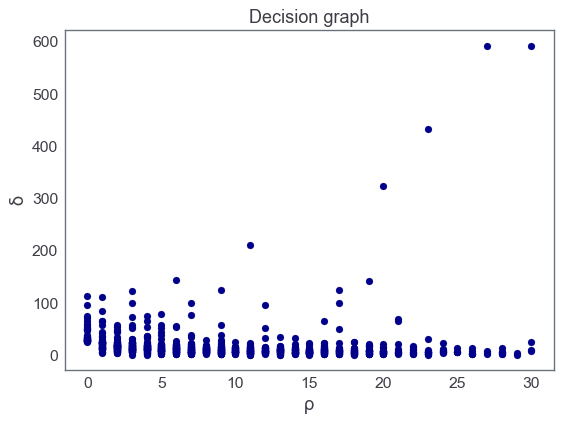

In [7]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter(rho,delta, c='Darkblue')
plt.xlabel("ρ")
plt.ylabel("ẟ")
plt.title("Decision graph")
plt.show()

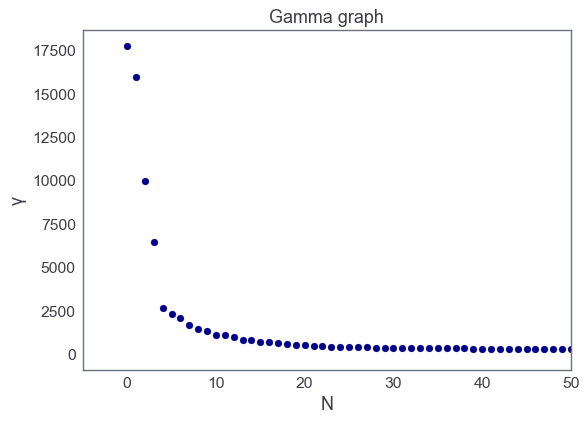

In [8]:
gamma.sort(reverse = True)
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(gamma))], gamma, c='Darkblue')
plt.xlabel("N")
plt.xlim(-5,50)
plt.ylabel("γ")
plt.title("Gamma graph")
plt.show()

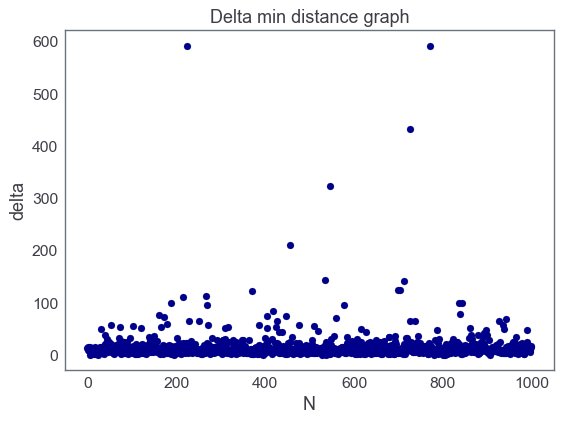

In [9]:
plt.figure(figsize=(7, 5),dpi = 90)
plt.scatter([i for i in range(len(delta))], delta, c='Darkblue')
plt.xlabel("N")
#plt.xlim(-5,100)
plt.ylabel("delta")
plt.title("Delta min distance graph")
plt.show()

{-1000: 1000, 699: 2000, 457: 3000, 224: 4000, 725: 5000, 771: 6000, 547: 7000, 713: 8000}


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


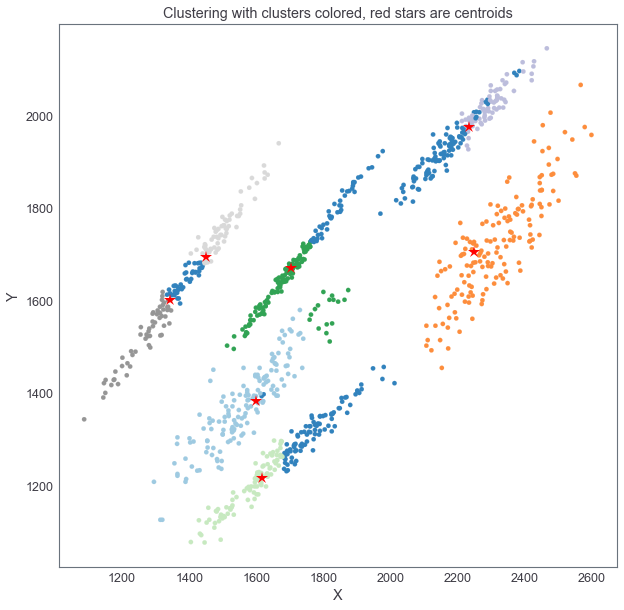

In [10]:
# prepare a dictionnary to assign each cluster a color
new_colors = {}
index = 1000
for element in clusters.values():
    if element in new_colors:
        continue
    else :
        new_colors[element] = index
        index+=1000


print(new_colors)
# plot the final scatter plot, each color represent one cluster
dfB.plot.scatter(x='X',y='Y',
                 color=[new_colors[clusters[i]] for i in clusters],
                 cmap='tab20c',
                 figsize=(10,10),
                 title = 'Clustering with clusters colored, red stars are centroids',
                 #c  = 'g',
                )

# plot the centroid with a red star
X = dfB['X']
Y = dfB['Y']
for idx in enumerate(centers):
    plt.plot(X[idx[1]], Y[idx[1]], 'red', marker = '*', markersize=12)
    if idx[1] == -1000:
        plt.plot(X[idx[0]], Y[idx[0]], color = 'black')
    #plt.text(X[idx[1]], Y[idx[1]], idx)



In [11]:
d = pd.Series(delta)
d.describe()

count    1000.000000
mean       16.777358
std        35.215357
min         1.000000
25%         6.082763
50%        10.246835
75%        17.000000
max       592.141875
dtype: float64

In [12]:
print(list(clusters.values()))

[-1000, 699, 699, -1000, 457, -1000, 224, -1000, 224, 725, -1000, 771, -1000, 699, -1000, 771, 725, 457, 457, 457, 771, 699, 771, -1000, -1000, -1000, -1000, 771, 224, 725, 699, -1000, 725, 725, 457, 224, 547, -1000, 457, 457, 699, 699, 771, 457, 699, 725, -1000, 699, -1000, 699, 457, 699, 713, 457, -1000, -1000, 224, 725, 457, -1000, 725, 224, 699, 699, 457, -1000, 224, -1000, 224, 457, 771, -1000, -1000, 457, 457, 457, 699, -1000, 699, 547, 725, 725, 224, 713, -1000, 457, 699, 771, 699, 699, -1000, 725, -1000, -1000, 547, -1000, 547, 224, 457, 699, 725, 224, 699, 457, 771, 771, 547, -1000, 224, -1000, -1000, 771, 224, 713, -1000, -1000, 725, -1000, 699, -1000, 713, 457, -1000, 547, -1000, 699, 725, 771, -1000, 547, 547, -1000, 224, 224, 547, -1000, 224, 725, 725, 457, 457, 457, -1000, 224, 547, -1000, 547, 457, 224, 725, 699, -1000, 713, 457, 457, 713, 713, 224, -1000, 224, 725, 457, 547, 224, -1000, 699, 224, 699, -1000, -1000, 699, 699, 224, 457, 725, 224, 699, -1000, 699, 457, 547

In [13]:
print(centers)
print(len(centers), "centers")

{224: 224, 457: 457, 547: 547, 699: 699, 713: 713, 725: 725, 771: 771}
7 centers


computation time is :
0.0045642852783203125 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'DBSCAN clustering'}, xlabel='X', ylabel='Y'>

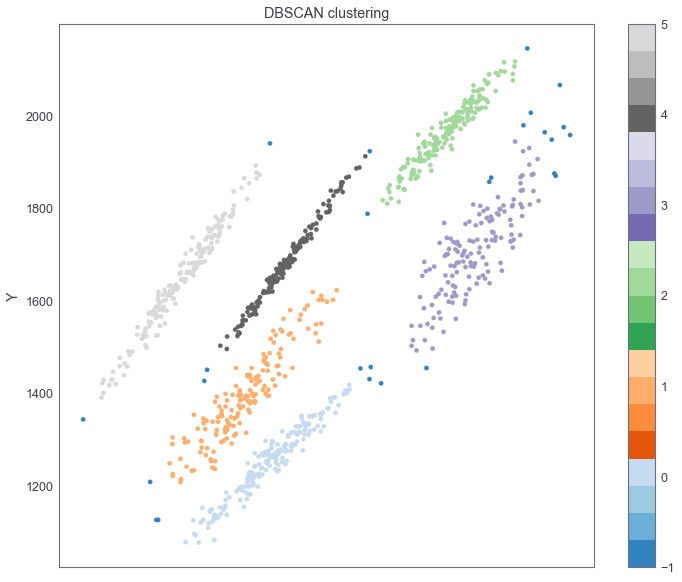

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = DBSCAN(eps=0.15, min_samples=5).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")

dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'DBSCAN clustering',
                 #c  = 'g',
                )

computation time is :
2.592569589614868 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Mean shift clustering'}, xlabel='X', ylabel='Y'>

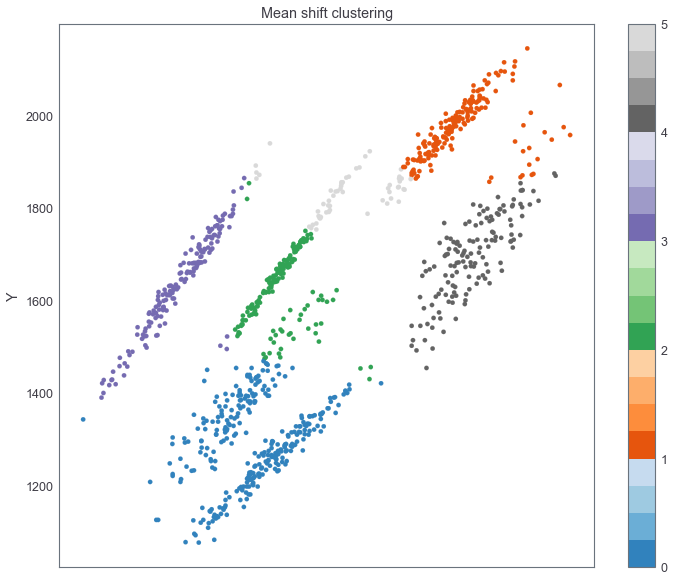

In [15]:
from sklearn.cluster import MeanShift
start = time.time()
X = StandardScaler().fit_transform(XB)
clustering = MeanShift(bandwidth = 0.5).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=clustering.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Mean shift clustering',
                 #c  = 'g',
                )

computation time is :
0.05649852752685547 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'KMeans clustering with k = 6'}, xlabel='X', ylabel='Y'>

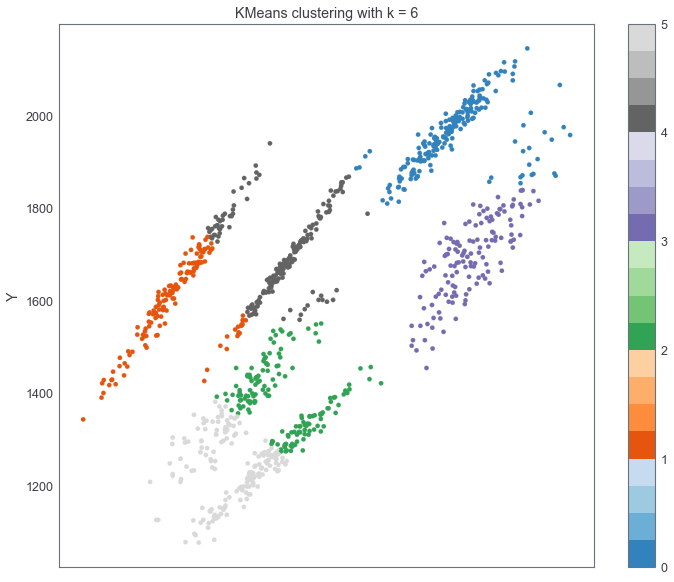

In [16]:
from sklearn.cluster import KMeans

start = time.time()
X = StandardScaler().fit_transform(XB)
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=kmeans.labels_,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'KMeans clustering with k = 6',
                 #c  = 'g',
                )

computation time is :
0.015575170516967773 sec


C:\Users\ready\anaconda3\envs\env_pytorch\lib\site-packages\pandas\plotting\_matplotlib\core.py:244: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


<AxesSubplot:title={'center':'Gaussian mixture clustering with n = 6'}, xlabel='X', ylabel='Y'>

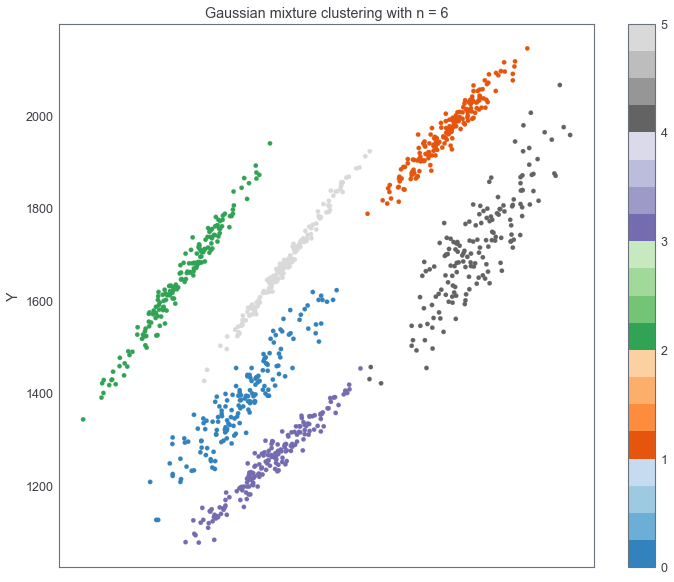

In [17]:
from sklearn.mixture import GaussianMixture

start = time.time()
X = StandardScaler().fit_transform(XB)
gm = GaussianMixture(n_components=6, random_state=0, covariance_type = "tied").fit_predict(X)
end = time.time()
print('computation time is :')
print(end - start, "sec")
dfB.plot.scatter(x='X',y='Y',
                 color=gm,
                 cmap='tab20c',
                 figsize=(12,10),
                 title = 'Gaussian mixture clustering with n = 6',
                 #c  = 'g',
                )